In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Choose relevant working path
# %cd drive/My\ Drive/2020_Fall/'Captstone(297)'/data
%cd drive/My\ Drive/'Capstone(297)'/data

Mounted at /content/drive
/content/drive/My Drive/Capstone(297)/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
# pd.set_option('display.max_rows', None)

FOLDER = "image_new"

## Load Data

In [ ]:
with open(f'./listing_cooc_new.pkl','rb') as f: new_listing = pickle.load(f)
new_listing_cooc = list(new_listing.keys())

In [ ]:
listings = pd.read_csv(f'./listing.csv')
listings.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,guid,created,updated,address_id,bedrooms,coming_soon_date,competitive_bidding_expiration_date,county,description,engagement_agreement_end,engagement_agreement_start,full_baths,grade,half_baths,hoa_fee,land_square_footage,latitude,listed_date,living_square_feet,longitude,loss_date,loss_type,market,marketing_budget,marketing_status,neighborhood,on_mls,price,property_type,publish_date,rex_url,sales,school_district_id,school_district_name,signed_date,sold_date,status,stories,timezone_id,total_baths,total_baths_calculated,total_rooms,year_built,geom
0,3,7a51c98bb10b4f04a3ef19e6ca6605a1,2015-03-30 21:20:17,2018-02-21 21:14:36,4,4.0,NaN,2016-05-12 10:00:44,Ventura,"Single story, 4 bedrooms, 3 baths, plus bonus ...",2015-09-08,2015-04-08,NaN,NaN,NaN,NaN,21300.0,34.198950,2015-05-01,2932.0,-118.899352,NaN,NaN,VC,LOW,0,NaN,0,980000.0,SINGLE,2015-05-01 00:00:00,1335-calle-pecos,VC,NaN,NaN,NaN,2015-09-11,SOLD,1.0,America/Los_Angeles,3.0,NaN,8.0,1963.0,NaN
1,22,63390d5e80d94d62875224a90d599f2f,2015-04-22 19:34:25,2015-04-22 19:34:26,20,3.0,NaN,NaN,Los Angeles,NaN,NaN,NaN,2.0,NaN,0.0,NaN,4549.0,34.015585,NaN,1274.0,-118.409200,NaN,NaN,LA,LOW,0,NaN,0,NaN,SINGLE,2015-04-22 19:34:26,3848-spad-pl,LA,NaN,NaN,NaN,NaN,PREVIEW,0.0,America/Los_Angeles,2.0,2.0,0.0,1947.0,NaN
2,24,2b2ccefd58184bccb82a7af010ac6a58,2015-04-22 21:17:21,2018-02-21 21:29:29,21,12.0,NaN,2016-05-12 10:00:22,Los Angeles,Oceanfront estate features three homes and a p...,NaN,NaN,2.0,NaN,0.0,NaN,141570.0,34.023865,2015-03-01,11510.0,-118.787080,NaN,NaN,LA,LOW,0,NaN,0,44000000.0,SINGLE,2015-03-01 00:00:00,rex1-pacific-coast-hwy,LA,NaN,NaN,NaN,2015-03-31,SOLD,1.0,America/Los_Angeles,12.0,2.0,33.0,2015.0,NaN
3,26,890de2d248d34c4f832ad8294983f6dd,2015-04-24 19:08:36,2015-04-24 19:08:37,23,3.0,NaN,NaN,Orange,NaN,NaN,NaN,2.0,NaN,0.0,NaN,9583.0,33.472814,NaN,1242.0,-117.632560,NaN,NaN,OC,LOW,0,NaN,0,NaN,SINGLE,2015-04-24 19:08:37,2934-hierro,OC,NaN,NaN,NaN,NaN,PREVIEW,1.0,America/Los_Angeles,2.0,2.0,5.0,1985.0,NaN
4,28,f3923ae4cae248b5b236441a0ec65a05,2015-04-30 20:39:13,2015-05-04 19:18:23,24,3.0,NaN,NaN,Ventura,Custom Property Description Here,NaN,NaN,2.0,NaN,0.0,NaN,5016.0,34.183448,NaN,1436.0,-118.954360,NaN,NaN,VC,LOW,0,NaN,0,NaN,SINGLE,2015-05-04 19:18:23,455-san-vincente-cir,VC,NaN,NaN,NaN,NaN,CLAIMED,1.0,America/Los_Angeles,2.0,2.0,6.0,1970.0,NaN


In [ ]:
images = pd.read_csv(f'./listing_image.csv')
images.head(5)

,listing_id,listing_image_order,created,public_url
0,3,0,2015-10-22,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
1,3,19,2015-10-22,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
2,3,20,2017-04-11,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
3,24,0,2015-10-22,https://cdn.rexhomes.com/listing/2b2ccefd58184...
4,24,3,2015-10-22,https://cdn.rexhomes.com/listing/2b2ccefd58184...


## Data Processing

In [ ]:
new_listing_cooc_df = listings[listings['rex_url'].isin(new_listing_cooc)]
new_listing_cooc_df = new_listing_cooc_df[['id','rex_url']]
new_listing_cooc_df.head()

,id,rex_url
25,74,175-sequoia-dr
159,257,840-e-green-st-unit-224
264,383,31373-pacific-coast-hwy
289,412,1711-camino-de-la-costa-unit-4
313,439,19250-knapp-st


In [ ]:
new_images_df = images.merge(new_listing_cooc_df, left_on="listing_id", right_on="id", how = "inner")
new_images_df = new_images_df.drop(columns=['id'])
new_images_df

,listing_id,listing_image_order,created,public_url,rex_url
0,74,0,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr
1,74,2,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr
2,74,6,2017-04-11,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr
3,74,22,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr
4,257,0,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224
...,...,...,...,...,...
9554,130994,6,2020-10-01,https://cdn.rexhomes.com/listing/5f481faf172f4...,22100-burbank-blvd-unit-225c
9555,130994,7,2020-10-01,https://cdn.rexhomes.com/listing/5f481faf172f4...,22100-burbank-blvd-unit-225c
9556,130994,8,2020-10-01,https://cdn.rexhomes.com/listing/5f481faf172f4...,22100-burbank-blvd-unit-225c
9557,130994,9,2020-10-01,https://cdn.rexhomes.com/listing/5f481faf172f4...,22100-burbank-blvd-unit-225c


In [ ]:
num_unique_listings = len(new_images_df.listing_id.unique())
print("The number of unique co-occurred listings is", num_unique_listings)

The number of unique co-occurred listings is 395


## Download Images From Web

In [ ]:
# download images from url

test_image_urls = list(new_images_df['public_url'])
for i, test_image_url in enumerate(test_image_urls):
    urllib.request.urlretrieve(test_image_url, f"./{FOLDER}/"+str(i)+'.jpg')

In [ ]:
img_names = []
for i in range(len(new_images_df)):
    img_names.append(str(i)+'.jpg')
new_images_df['image_file'] = img_names

In [ ]:
images = new_images_df.copy()

## Prepare Label Features

In [ ]:
# PlacesCNN to predict the scene category, attribute, and class activation map in a single pass
# for indoor outdoor classification

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
import cv2
from PIL import Image


 # hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)
    
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

In [ ]:
# load the test image
# img_url = 'http://places.csail.mit.edu/demo/6.jpg'
# os.system('wget %s -q -O test.jpg' % img_url)
example_image = f'./{FOLDER}/'+str(list(images.image_file)[2])
img = Image.open(example_image)
input_img = V(tf(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# print('RESULT ON ' + img_url)

# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

--TYPE OF ENVIRONMENT: indoor


### Drop Noise Images

In [ ]:
delete_indices = [2]
for i in range(3, len(images)):
  another_example_image = f'./{FOLDER}/'+str(list(images.image_file)[i])
  img = Image.open(another_example_image)
  another_input_img = V(tf(img).unsqueeze(0))
  if (input_img[0][0] == another_input_img[0][0]).all():
    delete_indices.append(i)

In [ ]:
# remove rows with such indices from dataset
images = images.drop(delete_indices)
images.head()

,listing_id,listing_image_order,created,public_url,rex_url,image_file
0,74,0,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,0.jpg
1,74,2,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,1.jpg
3,74,22,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,3.jpg
4,257,0,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,4.jpg
5,257,4,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,5.jpg


### Add Indoor/Outdoor Labels

In [ ]:
# indoor: 0, outdoor: 1
indoor_outdoor_list = np.array([0]*len(images))
for i in range(len(images)):
    example_image = f'./{FOLDER}/'+str(list(images.image_file)[i])
    img = Image.open(example_image)
    input_img = V(tf(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image >= 0.5:
        indoor_outdoor_list[i] = 1

In [ ]:
# 0 indoor 1 outdoor
images['indoor_or_outdoor'] = indoor_outdoor_list

In [ ]:
images.head(20)

,listing_id,listing_image_order,created,public_url,rex_url,image_file,indoor_or_outdoor
0,74,0,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,0.jpg,1
1,74,2,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,1.jpg,1
3,74,22,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,3.jpg,1
4,257,0,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,4.jpg,1
5,257,4,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,5.jpg,0
7,257,17,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,7.jpg,0
8,383,0,2018-04-02,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,8.jpg,1
10,383,2,2018-04-01,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,10.jpg,1
11,383,3,2018-04-02,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,11.jpg,0
12,383,4,2018-04-01,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,12.jpg,0


In [ ]:
images.to_csv(f"./new_images_dataset.csv", index=False)

### Extract Image Features with Places365 Model

In [ ]:
# extract image features

# -*- coding: utf-8 -*-
'''VGG-ImageNetPlaces365-hybrid model for Keras
1000 classes from the ImageNet and the 365 classes from
the Places365-Standard were merged to train a VGG16-based model (Hybrid1365-VGG)
# Reference:
- [Places: A 10 million Image Database for Scene Recognition](http://places2.csail.mit.edu/PAMI_places.pdf)
'''

from __future__ import division, print_function
import os

import warnings

from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils


WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16_Hybrid_1365(include_top=True, weights='places',
                      input_tensor=None, input_shape=None,
                      pooling=None,
                      classes=1365):
    """Instantiates the VGG-ImageNetPlaces365-hybrid architecture.
    Optionally loads weights pre-trained
    on Places. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
                 'places' (pre-training on Places),
                 or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`, or invalid input shape
        """

    if not (weights in {'places', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `places` '
                         '(pre-training on Places), '
                         'or the path to the weights file to be loaded.')

    if weights == 'places' and include_top and classes != 1365:
        raise ValueError('If using `weights` as places with `include_top`'
                         ' as true, `classes` should be 1365')


    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor



    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block1_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)



    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block2_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)



    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)



    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)



    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool", padding='valid')(x)



    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dropout(0.5, name='drop_fc1')(x)

        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dropout(0.5, name='drop_fc2')(x)

        x = Dense(1365, activation='softmax', name='predictions')(x)

    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input


    # Create model.
    model = Model(inputs, x, name='vgg16-hybrid1365')

    # load weights
    if weights == 'places':
        if include_top:
            weights_path = get_file('vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')


    elif weights is not None:
        model.load_weights(weights)



    return model


In [ ]:
import numpy as np
from PIL import Image
from cv2 import resize

# from vgg16_hybrid_places_1365 import VGG16_Hybrid_1365

# TEST_IMAGE_URL = 'http://places2.csail.mit.edu/imgs/demo/6.jpg'

# image = Image.open(urllib2.urlopen(TEST_IMAGE_URL))

image_features = []
image_features_dict = {}

model = VGG16_Hybrid_1365(weights='places', include_top=False)

for i in range(len(images)):
  example_image = f'./{FOLDER}/'+str(list(images.image_file)[i])
  image = Image.open(example_image)
  image = np.array(image, dtype=np.uint8)
  image = resize(image, (224, 224))
  image = np.expand_dims(image, 0)

  features = model.predict(image)
  places365_extracted_features = features.reshape(1, 7*7*512)[0]
  image_features.append(places365_extracted_features)
  image_features_dict[list(images.image_file)[i]] = places365_extracted_features

In [ ]:
with open(f'./places365_extracted_features.pkl','wb') as f: pickle.dump(image_features, f)

In [ ]:
with open(f'./places365_extracted_features.pkl','rb') as f: image_features = pickle.load(f)

In [ ]:
image_features = np.array(image_features)

In [ ]:
# first use PCA to get top 100 components
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(image_features)

# first component from the 100 components
pca_extracted_image_features = pca.transform(image_features)

In [ ]:
with open(f'./places365_pca_extracted_features.pkl','wb') as f: pickle.dump(pca_extracted_image_features, f)

In [ ]:
pca_extracted_image_features = pca_extracted_image_features.tolist()
images['image_features'] = pca_extracted_image_features

In [ ]:
images.head()

,listing_id,listing_image_order,created,public_url,rex_url,image_file,indoor_or_outdoor,image_features
0,74,0,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,0.jpg,1,"[-171.64894104003906, -46.409934997558594, -10..."
1,74,2,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,1.jpg,1,"[-175.43150329589844, 31.321495056152344, -64...."
3,74,22,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,3.jpg,1,"[-201.75657653808594, -50.73617935180664, -77...."
4,257,0,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,4.jpg,1,"[-215.32273864746094, 37.79015350341797, 15.38..."
5,257,4,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,5.jpg,0,"[141.94659423828125, 99.68537902832031, -121.8..."


In [ ]:
images.to_csv(f"./new_images_dataset.csv", index=False)

### Add Room Category Labels for Indoor Room Images

In [ ]:
# Model from REX api

"""
This file is a standalone, importable script for production use of the room
classification model. At minimum, it demonstrates example usage. There are two
supported methods:

1. Running an ONNX model directly
2. Invoking the REX vision API (which hosts the ONNX model)
"""


from imageio import imread
import onnxruntime
import numpy as np
import requests
import argparse
import os


MODEL_URL = "https://org-rex-data.s3-us-west-2.amazonaws.com/vision/onnx/ckpt-6clsrm-resnet18-8792val.onnx"
CLASS_NAMES = ["bathroom", "bedroom", "dining_room", "kitchen", "living_room", "other"]


parser = argparse.ArgumentParser()
parser.add_argument('--path', default='samples/bathroom.jpg')
parser.add_argument('--mode', default='onnx', choices=('onnx', 'api'))
parser.add_argument('--local', action='store_true')


def classify_room(
        image, mode='onnx', local=False, content_type='image/jpeg'):
    if mode == 'api':
        return classify_room_with_api(image, local, content_type)
    return classify_room_with_onnx(image)


def classify_room_with_api(image, local=False, content_type='image/jpeg'):
    url = 'http://localhost:5000' if local \
        else 'https://qa-vision-room-api.rexchange.com'

    response = requests.post(
        '{}/classification/?h={}&w={}'.format(
            url,
            image.shape[0],
            image.shape[1],
        ),  # don't forget trailing slash
        files={'file': ('sample.jpg', image, content_type)})

    try:
        return response.json()['prediction']
    except:
        raise UserWarning("Is the API online? Or is the API buggy? "
            "Tried to ping {}".format(url))


def classify_room_with_onnx(image, path_model="./tmp/model.onnx"):
    if not os.path.exists(path_model):
        download_model_to(path_model)

    ort_session = onnxruntime.InferenceSession(path_model)

    testset = ADE20kRoomsDataset(images=(image,), split='validation')
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False, num_workers=1)

    x, _ = next(iter(testloader))  # only supports 1 sample

    # compute ONNX Runtime output prediction
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    ort_outs = ort_session.run(None, ort_inputs)
    prediction = np.argmax(ort_outs[0])
    return CLASS_NAMES[prediction]


def download_model_to(path):
    print(" * Downloading classification model... (happens only the first time)")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        response = requests.get(MODEL_URL)
        f.write(response.content)
    print(" * All models downloaded")


def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


############################################################
# BELOW IS COPY-PASTED FROM vision/cls_room/data/ade20k.py #
############################################################

from torch.utils.data.dataset import Dataset
from torchvision import transforms
from pathlib import Path
# from scipy.misc import imresize
from skimage.transform import resize
from PIL import Image
from imageio import imread

import glob
import random
import numpy as np
import torch

SPLIT_TRAIN = 'training'
SPLIT_VAL = 'validation'
VALID_SPLITS = (SPLIT_TRAIN, SPLIT_VAL)


CLASS_NAMES = [
    "bathroom", "bedroom", "dining_room", "kitchen", "living_room", "other"]


class ADE20kRoomsDataset(Dataset):

    def __init__(self, image_dim=224, root='./data/ADE20K_rooms',
            split='training', image_paths=(), images=()):

        self.image_dim = image_dim
        assert split in VALID_SPLITS, "Split '{}' must be one of: {}".format(
            split, VALID_SPLITS)
        self.split = split

        self.images = None
        if image_paths:
            self.index_to_label = CLASS_NAMES
            self.image_paths = list(image_paths)
            self.labels = [CLASS_NAMES[0]] * len(self.image_paths)
        elif images:
            self.index_to_label = CLASS_NAMES
            self.images = images
            self.labels = [CLASS_NAMES[0]] * len(self.images)
        else:
            self.image_paths, self.labels, self.index_to_label = \
                self.get_image_paths_labels(root)
        assert self.index_to_label == CLASS_NAMES

        # mean and std
        self.img_transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    def get_image_paths_labels(self, root):
        path = Path(root) / 'images' / self.split / '*' / '*' / '*.jpg'

        samples = []
        labels = set()
        for image_path in glob.iglob(str(path)):
            label = Path(image_path).parent.name
            samples.append((image_path, label))
            labels.add(label)

        random.shuffle(samples)
        index_to_label = sorted(list(labels))
        image_paths, labels = zip(*samples)
        return image_paths, labels, index_to_label


    def _scale_and_crop(self, img, cropSize, is_train):
        h, w = img.shape[0], img.shape[1]

        if is_train:
            # random scale
            scale = random.random() + 0.5     # 0.5-1.5
            scale = max(scale, 1. * cropSize / (min(h, w) - 1))
        else:
            # scale to crop size
            scale = 1. * cropSize / (min(h, w) - 1)

        img_scale = imresize(img, scale, interp='bilinear')
        # img_scale = img

        h_s, w_s = img_scale.shape[0], img_scale.shape[1]
        if is_train:
            # random crop
            x1 = random.randint(0, w_s - cropSize)
            y1 = random.randint(0, h_s - cropSize)
        else:
            # center crop
            x1 = (w_s - cropSize) // 2
            y1 = (h_s - cropSize) // 2

        img_crop = img_scale[y1: y1 + cropSize, x1: x1 + cropSize, :]
        return img_crop,

    def _flip(self, img):
        img_flip = img[:, ::-1, :]
        return img_flip

    def __getitem__(self, index):
        if self.images is not None:
            img = self.images[index]
        else:
            image_path = self.image_paths[index]
            assert Path(image_path).exists(), \
                "Image {} does not exist.".format(image_path)

            img = imread(image_path, pilmode='RGB')
        label = self.labels[index]
        label = self.index_to_label.index(label)

        # random scale, crop, flip
        if self.image_dim > 0:
            img, = self._scale_and_crop(
                img, self.image_dim, self.split == SPLIT_TRAIN)
            if random.choice([-1, 1]) > 0:
                img = self._flip(img)

        # image to float
        img = img.astype(np.float32) / 255.
        img = img.transpose((2, 0, 1))

        # to torch tensor
        image = torch.from_numpy(img)

        # substracted by mean and divided by std
        image = self.img_transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths) if hasattr(self, 'image_paths') \
            else len(self.images)


##################
# END COPY-PASTE #
##################



In [ ]:
# an example of room classification
example_path = f'./{FOLDER}/'+str(list(images.image_file)[12])
# image = imread(example_path, pilmode='RGB')
image = imread(example_path)
prediction = classify_room(image)
print(prediction)


kitchen


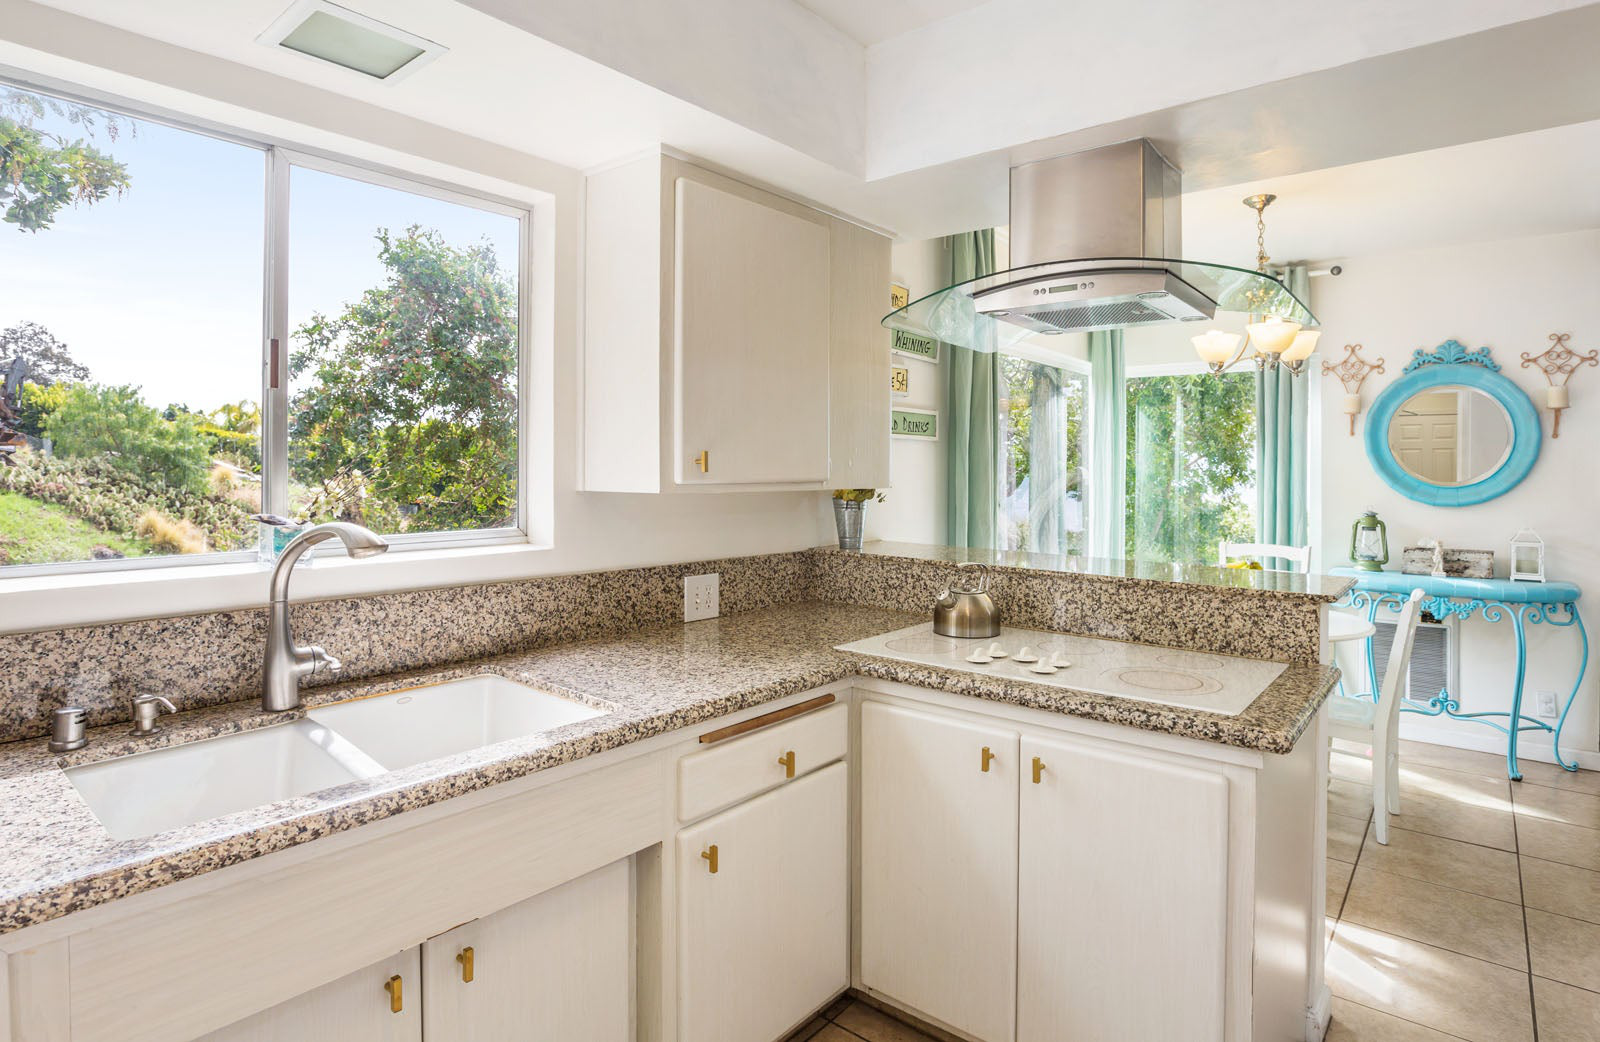

In [ ]:
img = Image.open(example_path, 'r')
img

In [ ]:
room_class_dict = {}
CLASS_NAMES = ["bathroom", "bedroom", "dining_room", "kitchen", "living_room", "other"]
for type_of_room in CLASS_NAMES:
  room_class_dict[type_of_room] = np.zeros(len(images))

for i in range(len(images)):
  if list(images['indoor_or_outdoor'])[i] == 0:
    path = f'./{FOLDER}/'+str(list(images.image_file)[i])
    image = imread(path)
    prediction = classify_room(image)
    room_class_dict[prediction][i] = 1

In [ ]:
room_class_dict

{'bathroom': array([0., 0., 0., ..., 0., 0., 0.]),
 'bedroom': array([0., 0., 0., ..., 1., 0., 0.]),
 'dining_room': array([0., 0., 0., ..., 0., 0., 0.]),
 'kitchen': array([0., 0., 0., ..., 0., 1., 1.]),
 'living_room': array([0., 0., 0., ..., 0., 0., 0.]),
 'other': array([0., 0., 0., ..., 0., 0., 0.])}

In [ ]:
for type_of_room in CLASS_NAMES:
  images[type_of_room] = room_class_dict[type_of_room]

In [ ]:
images.head(20)

,listing_id,listing_image_order,created,public_url,rex_url,image_file,indoor_or_outdoor,image_features,bathroom,bedroom,dining_room,kitchen,living_room,other
0,74,0,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,0.jpg,1,"[-171.64894104003906, -46.409934997558594, -10...",0.0,0.0,0.0,0.0,0.0,0.0
1,74,2,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,1.jpg,1,"[-175.43150329589844, 31.321495056152344, -64....",0.0,0.0,0.0,0.0,0.0,0.0
3,74,22,2015-10-22,https://cdn.rexhomes.com/listing/67d650c16bdf4...,175-sequoia-dr,3.jpg,1,"[-201.75657653808594, -50.73617935180664, -77....",0.0,0.0,0.0,0.0,0.0,0.0
4,257,0,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,4.jpg,1,"[-215.32273864746094, 37.79015350341797, 15.38...",0.0,0.0,0.0,0.0,0.0,0.0
5,257,4,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,5.jpg,0,"[141.94659423828125, 99.68537902832031, -121.8...",0.0,0.0,0.0,1.0,0.0,0.0
7,257,17,2016-02-24,https://cdn.rexhomes.com/listing/3a4162b0f6154...,840-e-green-st-unit-224,7.jpg,0,"[92.57672882080078, -119.60747528076172, -63.8...",0.0,0.0,0.0,0.0,1.0,0.0
8,383,0,2018-04-02,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,8.jpg,1,"[-275.4832458496094, -89.94664001464844, -45.9...",0.0,0.0,0.0,0.0,0.0,0.0
10,383,2,2018-04-01,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,10.jpg,1,"[-285.9609069824219, -27.655662536621094, -1.9...",0.0,0.0,0.0,0.0,0.0,0.0
11,383,3,2018-04-02,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,11.jpg,0,"[81.79533386230469, -156.45278930664062, -181....",0.0,1.0,0.0,0.0,0.0,0.0
12,383,4,2018-04-01,https://cdn.rexhomes.com/listing/a3b665d81c504...,31373-pacific-coast-hwy,12.jpg,0,"[29.063440322875977, 76.48741912841797, -84.86...",0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
images.to_csv(f"./new_images_dataset.csv", index=False)

## Clustering

In [ ]:
# clustering based on T-SNE results

from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt


def majority_vote(listing_id, df):
  curr_df = df[df['listing_id']==listing_id]
  majority_vote = Counter(list(curr_df.labels)).most_common(1)[0][0]
  return majority_vote

def cluster(indoor=False, room_type=None):
  if indoor==False:
    df = images[images['indoor_or_outdoor']==1]
  elif indoor==True:
    df = images[images['indoor_or_outdoor']==0][images[room_type]==1.0]

  image_features = [features for features in list(df['image_features'])]
  # image_features = [eval(features) for features in list(df['image_features'])]

  tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=300)
  tsne_results = tsne.fit_transform(image_features)
  tsne_results_normalized = MinMaxScaler().fit(tsne_results).transform(tsne_results)

  kmeans = KMeans(n_clusters = 4, random_state = 0)
  kmeans.fit(tsne_results)
  labels = kmeans.labels_
  df['labels'] = labels

  plt.figure(figsize=(8,8))
  plt.scatter(pd.DataFrame(tsne_results_normalized)[0],pd.DataFrame(tsne_results_normalized)[1], c=labels, cmap='plasma', alpha=0.5); 
  plt.show()

  cluster_dict = {}
  for listing_id in list(df.listing_id.unique()):
    most_vote_cluster = majority_vote(listing_id, df)
    cluster_dict[listing_id] = most_vote_cluster
  return cluster_dict


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2629 samples in 0.029s...
[t-SNE] Computed neighbors for 2629 samples in 1.728s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2629
[t-SNE] Computed conditional probabilities for sample 2000 / 2629
[t-SNE] Computed conditional probabilities for sample 2629 / 2629
[t-SNE] Mean sigma: 128.313459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.946518
[t-SNE] KL divergence after 300 iterations: 2.617330


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


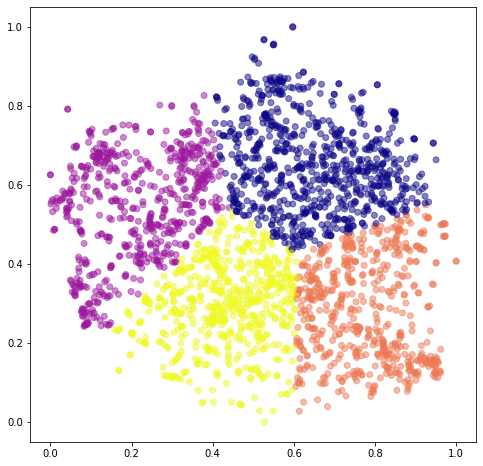

In [ ]:
outdoor_cluster_dict = cluster(False, None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1345 samples in 0.011s...
[t-SNE] Computed neighbors for 1345 samples in 0.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1345
[t-SNE] Computed conditional probabilities for sample 1345 / 1345
[t-SNE] Mean sigma: 188.955269
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.805717
[t-SNE] KL divergence after 300 iterations: 1.883559


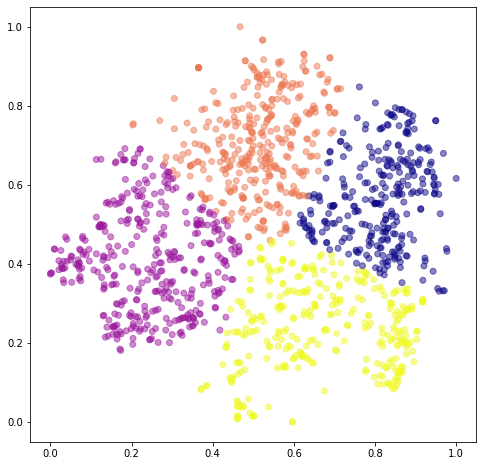

In [ ]:
indoor_bathroom_cluster_dict = cluster(True, 'bathroom')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1370 samples in 0.011s...
[t-SNE] Computed neighbors for 1370 samples in 0.439s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1370
[t-SNE] Computed conditional probabilities for sample 1370 / 1370
[t-SNE] Mean sigma: 195.848824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.588135
[t-SNE] KL divergence after 300 iterations: 2.067876


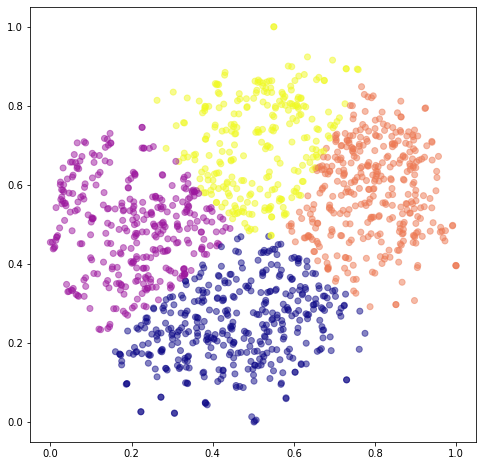

In [ ]:
indoor_bedroom_cluster_dict = cluster(True, 'bedroom')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 258 samples in 0.002s...
[t-SNE] Computed neighbors for 258 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 258 / 258
[t-SNE] Mean sigma: 214.956236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.921288
[t-SNE] KL divergence after 300 iterations: 1.599679


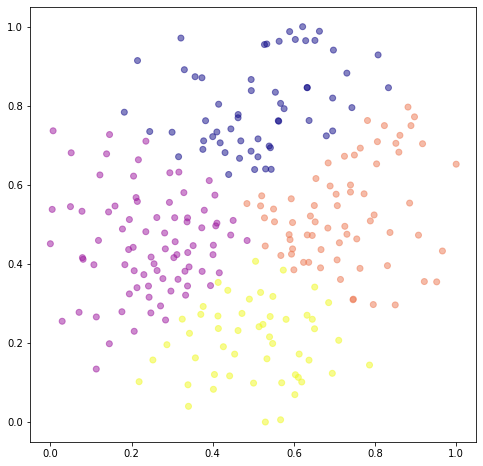

In [ ]:
indoor_dining_cluster_dict = cluster(True, 'dining_room')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1624 samples in 0.012s...
[t-SNE] Computed neighbors for 1624 samples in 0.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1624
[t-SNE] Computed conditional probabilities for sample 1624 / 1624
[t-SNE] Mean sigma: 193.382737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.072174
[t-SNE] KL divergence after 300 iterations: 2.242074


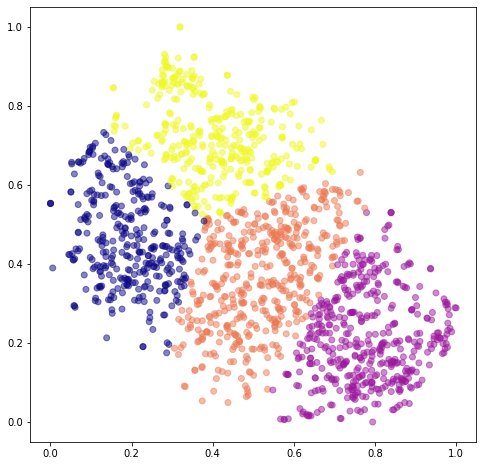

In [ ]:
indoor_kitchen_cluster_dict = cluster(True, 'kitchen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1202 samples in 0.011s...
[t-SNE] Computed neighbors for 1202 samples in 0.355s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1202
[t-SNE] Computed conditional probabilities for sample 1202 / 1202
[t-SNE] Mean sigma: 189.101566
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.787521
[t-SNE] KL divergence after 300 iterations: 2.331089


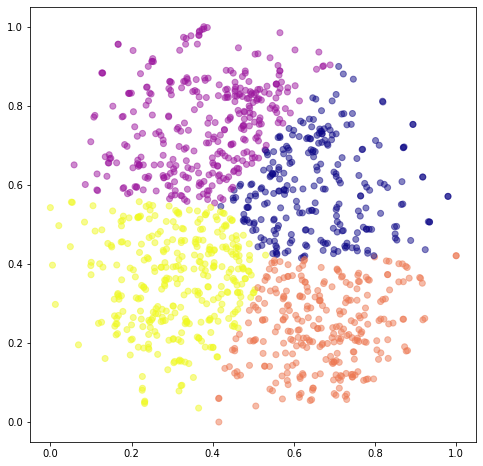

In [ ]:
indoor_living_cluster_dict = cluster(True, 'living_room')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 979 samples in 0.008s...
[t-SNE] Computed neighbors for 979 samples in 0.291s...
[t-SNE] Computed conditional probabilities for sample 979 / 979
[t-SNE] Mean sigma: 5.154009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.579582
[t-SNE] KL divergence after 300 iterations: 1.779365


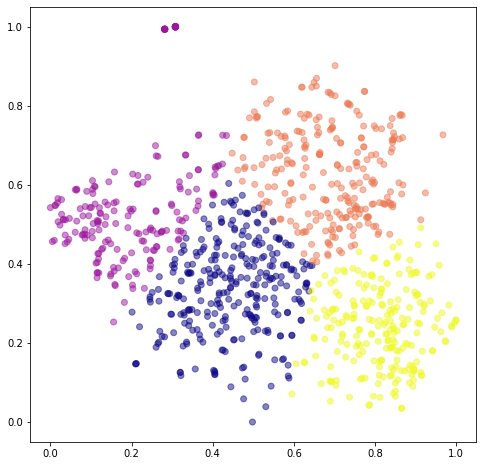

In [ ]:
indoor_other_cluster_dict = cluster(True, 'other')

In [ ]:
listing_image_features_df = pd.DataFrame({'listing_id': list(images.listing_id.unique())})
listing_image_features_df.head()

,listing_id
0,74
1,257
2,383
3,412
4,439


In [ ]:
# create a vector of clustered labels for each listing
# -1 means no such category of images exists for the listing

outdoor_cluster_values = []
for listing_id in list(listing_image_features_df.listing_id.unique()):
  if listing_id not in list(outdoor_cluster_dict.keys()):
    outdoor_cluster_values.append(-1)
  else:
    outdoor_cluster_values.append(outdoor_cluster_dict[listing_id])
listing_image_features_df['outdoor_cluster'] = outdoor_cluster_values

In [ ]:
indoor_bathroom_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_bathroom_cluster_dict.keys()):
    indoor_bathroom_cluster_values.append(-1)
  else:
    indoor_bathroom_cluster_values.append(indoor_bathroom_cluster_dict[listing_id])
listing_image_features_df['indoor_bathroom_cluster'] = indoor_bathroom_cluster_values

In [ ]:
indoor_bedroom_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_bedroom_cluster_dict.keys()):
    indoor_bedroom_cluster_values.append(-1)
  else:
    indoor_bedroom_cluster_values.append(indoor_bedroom_cluster_dict[listing_id])
listing_image_features_df['indoor_bedroom_cluster'] = indoor_bedroom_cluster_values

In [ ]:
indoor_dining_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_dining_cluster_dict.keys()):
    indoor_dining_cluster_values.append(-1)
  else:
    indoor_dining_cluster_values.append(indoor_dining_cluster_dict[listing_id])
listing_image_features_df['indoor_dining_cluster'] = indoor_dining_cluster_values

In [ ]:
indoor_kitchen_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_kitchen_cluster_dict.keys()):
    indoor_kitchen_cluster_values.append(-1)
  else:
    indoor_kitchen_cluster_values.append(indoor_kitchen_cluster_dict[listing_id])
listing_image_features_df['indoor_kitchen_cluster'] = indoor_kitchen_cluster_values

In [ ]:
indoor_living_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_living_cluster_dict.keys()):
    indoor_living_cluster_values.append(-1)
  else:
    indoor_living_cluster_values.append(indoor_living_cluster_dict[listing_id])
listing_image_features_df['indoor_living_cluster'] = indoor_living_cluster_values

In [ ]:
indoor_other_cluster_values = []
for listing_id in list(images.listing_id.unique()):
  if listing_id not in list(indoor_other_cluster_dict.keys()):
    indoor_other_cluster_values.append(-1)
  else:
    indoor_other_cluster_values.append(indoor_other_cluster_dict[listing_id])
listing_image_features_df['indoor_other_cluster'] = indoor_other_cluster_values

In [ ]:
listing_image_features_df.head()

,listing_id,outdoor_cluster,indoor_bathroom_cluster,indoor_bedroom_cluster,indoor_dining_cluster,indoor_kitchen_cluster,indoor_living_cluster,indoor_other_cluster
0,74,3,-1,-1,-1,-1,-1,-1
1,257,1,-1,-1,-1,2,2,-1
2,383,3,1,2,0,0,1,-1
3,412,2,3,-1,3,1,2,-1
4,439,2,1,0,1,2,0,2


In [ ]:
listing_image_features_df.to_csv(f"./clustered_listings_dataset.csv", index=False)

In [ ]:
# add rex_url
listings_with_rexurl = images[['listing_id', 'rex_url']].drop_duplicates()
new_listing_image_features = listing_image_features_df.merge(listings_with_rexurl, left_on="listing_id", right_on="listing_id", how="inner")
new_listing_image_features

,listing_id,outdoor_cluster,indoor_bathroom_cluster,indoor_bedroom_cluster,indoor_dining_cluster,indoor_kitchen_cluster,indoor_living_cluster,indoor_other_cluster,rex_url
0,74,3,-1,-1,-1,-1,-1,-1,175-sequoia-dr
1,257,1,-1,-1,-1,2,2,-1,840-e-green-st-unit-224
2,383,3,1,2,0,0,1,-1,31373-pacific-coast-hwy
3,412,2,3,-1,3,1,2,-1,1711-camino-de-la-costa-unit-4
4,439,2,1,0,1,2,0,2,19250-knapp-st
...,...,...,...,...,...,...,...,...,...
390,125111,0,1,2,-1,1,3,3,15518-california-ave
391,125356,1,1,3,0,2,1,-1,150-calle-rosa
392,127560,1,2,0,-1,2,0,2,1010-sycamore-ave-unit-101-south-pasadena
393,127794,0,2,2,-1,1,1,3,2952-w-avenue-34-los-angeles


In [ ]:
# add average image features (pca)

pca_features_dict = {}

for listing_id in list(images.listing_id.unique()):
  df = images[images['listing_id']==listing_id]
  image_features = np.array(list(df['image_features']))
  average_features = np.sum(image_features,axis=0)/len(image_features)
  pca_features_dict[listing_id] = list(average_features)

In [ ]:
new_listing_image_features['averaged_pca_features'] = list(pca_features_dict.values())
new_listing_image_features

,listing_id,outdoor_cluster,indoor_bathroom_cluster,indoor_bedroom_cluster,indoor_dining_cluster,indoor_kitchen_cluster,indoor_living_cluster,indoor_other_cluster,rex_url,averaged_pca_features
0,74,3,-1,-1,-1,-1,-1,-1,175-sequoia-dr,"[-182.94567362467447, -21.941539764404297, -83..."
1,257,1,-1,-1,-1,2,2,-1,840-e-green-st-unit-224,"[6.400194803873698, 5.9560190836588545, -56.77..."
2,383,3,1,2,0,0,1,-1,31373-pacific-coast-hwy,"[-78.11809902191162, 36.24896113077799, -96.57..."
3,412,2,3,-1,3,1,2,-1,1711-camino-de-la-costa-unit-4,"[11.806087242929559, 31.539034768154746, -32.9..."
4,439,2,1,0,1,2,0,2,19250-knapp-st,"[42.9681173324585, -18.60111963748932, 3.29038..."
...,...,...,...,...,...,...,...,...,...,...
390,125111,0,1,2,-1,1,3,3,15518-california-ave,"[23.851562118530275, -34.40980913162232, -14.1..."
391,125356,1,1,3,0,2,1,-1,150-calle-rosa,"[-47.11508337656657, 18.470575014750164, 81.74..."
392,127560,1,2,0,-1,2,0,2,1010-sycamore-ave-unit-101-south-pasadena,"[-20.207102430718287, 33.722855057035176, -37...."
393,127794,0,2,2,-1,1,1,3,2952-w-avenue-34-los-angeles,"[-51.76280610457711, 51.41458138693934, 109.18..."


In [ ]:
new_listing_image_features.to_csv(f'./final_image_features.csv', index=False)

## Note

We use silhouette score to pick number of clusters. Below are code for an example.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
# silhouette (cluster = 3)

from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt

def cluster(indoor=False, room_type=None):
  if indoor==False:
    df = images[images['indoor_or_outdoor']==1]
  elif indoor==True:
    df = images[images['indoor_or_outdoor']==0][images[room_type]==1.0]

  # image_features = [features for features in list(df['image_features'])]
  image_features = [eval(features) for features in list(df['image_features'])]

  tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=300)
  tsne_results = tsne.fit_transform(image_features)
  tsne_results_normalized = MinMaxScaler().fit(tsne_results).transform(tsne_results)

  kmeans = KMeans(n_clusters = 3, random_state = 0)
  kmeans.fit(tsne_results)
  labels = kmeans.labels_
  df['labels'] = labels
  df['tsne_0'] = tsne_results[:,0]
  df['tsne_1'] = tsne_results[:,1]
  df = df[['tsne_0','tsne_1','labels']]

  silplot(df.values, df['labels'], kmeans, pointlabels=None)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1370 samples in 0.013s...
[t-SNE] Computed neighbors for 1370 samples in 0.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1370
[t-SNE] Computed conditional probabilities for sample 1370 / 1370
[t-SNE] Mean sigma: 195.848824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.912560
[t-SNE] KL divergence after 300 iterations: 2.123721
For n_clusters = 3, the average silhouette_score is 0.4053439977834147.


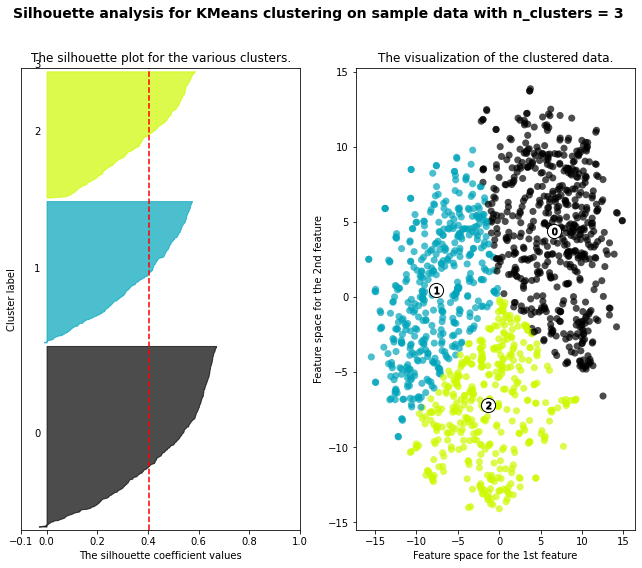

In [ ]:
indoor_bedroom_cluster_dict = cluster(True, 'bedroom')

In [ ]:
# silhouette (cluster = 4)

from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt

def cluster(indoor=False, room_type=None):
  if indoor==False:
    df = images[images['indoor_or_outdoor']==1]
  elif indoor==True:
    df = images[images['indoor_or_outdoor']==0][images[room_type]==1.0]

  # image_features = [features for features in list(df['image_features'])]
  image_features = [eval(features) for features in list(df['image_features'])]

  tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=300)
  tsne_results = tsne.fit_transform(image_features)
  tsne_results_normalized = MinMaxScaler().fit(tsne_results).transform(tsne_results)

  kmeans = KMeans(n_clusters = 4, random_state = 0)
  kmeans.fit(tsne_results)
  labels = kmeans.labels_
  df['labels'] = labels
  df['tsne_0'] = tsne_results[:,0]
  df['tsne_1'] = tsne_results[:,1]
  df = df[['tsne_0','tsne_1','labels']]

  silplot(df.values, df['labels'], kmeans, pointlabels=None)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1370 samples in 0.011s...
[t-SNE] Computed neighbors for 1370 samples in 0.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1370
[t-SNE] Computed conditional probabilities for sample 1370 / 1370
[t-SNE] Mean sigma: 195.848824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.010788
[t-SNE] KL divergence after 300 iterations: 2.105824
For n_clusters = 4, the average silhouette_score is 0.4153861749889162.


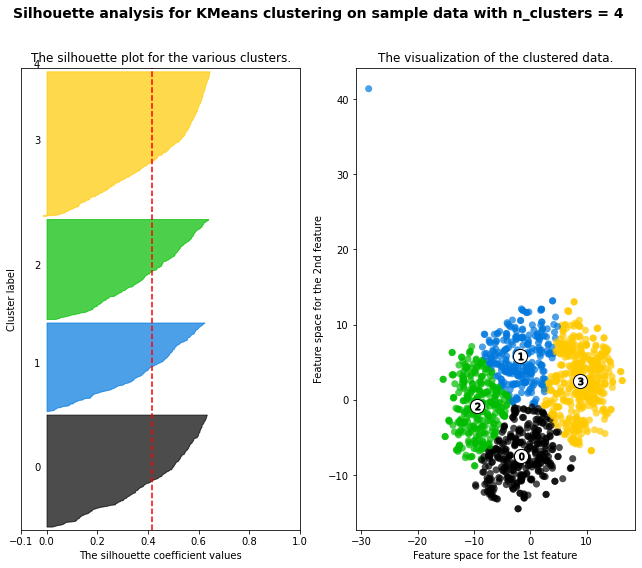

In [ ]:
indoor_bedroom_cluster_dict = cluster(True, 'bedroom')

## Appendix

In [ ]:
# helper function (deprecated image functions for scipy.misc)

"""
A collection of image utilities using the Python Imaging Library (PIL).
Note that PIL is not a dependency of SciPy and this module is not
available on systems that don't have PIL installed.
"""
from __future__ import division, print_function, absolute_import

# Functions which need the PIL

import numpy
import tempfile

from numpy import (amin, amax, ravel, asarray, arange, ones, newaxis,
                   transpose, iscomplexobj, uint8, issubdtype, array)

try:
    from PIL import Image, ImageFilter
except ImportError:
    import Image
    import ImageFilter


if not hasattr(Image, 'frombytes'):
    Image.frombytes = Image.fromstring

__all__ = ['fromimage', 'toimage', 'imsave', 'imread', 'bytescale',
           'imrotate', 'imresize', 'imshow', 'imfilter']



def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(uint8)



def imread(name, flatten=False, mode=None):
    """
    Read an image from a file as an array.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    name : str or file object
        The file name or file object to be read.
    flatten : bool, optional
        If True, flattens the color layers into a single gray-scale layer.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes for more
        details.
    Returns
    -------
    imread : ndarray
        The array obtained by reading the image.
    Notes
    -----
    `imread` uses the Python Imaging Library (PIL) to read an image.
    The following notes are from the PIL documentation.
    `mode` can be one of the following strings:
    * 'L' (8-bit pixels, black and white)
    * 'P' (8-bit pixels, mapped to any other mode using a color palette)
    * 'RGB' (3x8-bit pixels, true color)
    * 'RGBA' (4x8-bit pixels, true color with transparency mask)
    * 'CMYK' (4x8-bit pixels, color separation)
    * 'YCbCr' (3x8-bit pixels, color video format)
    * 'I' (32-bit signed integer pixels)
    * 'F' (32-bit floating point pixels)
    PIL also provides limited support for a few special modes, including
    'LA' ('L' with alpha), 'RGBX' (true color with padding) and 'RGBa'
    (true color with premultiplied alpha).
    When translating a color image to black and white (mode 'L', 'I' or
    'F'), the library uses the ITU-R 601-2 luma transform::
        L = R * 299/1000 + G * 587/1000 + B * 114/1000
    When `flatten` is True, the image is converted using mode 'F'.
    When `mode` is not None and `flatten` is True, the image is first
    converted according to `mode`, and the result is then flattened using
    mode 'F'.
    """

    im = Image.open(name)
    return fromimage(im, flatten=flatten, mode=mode)



def imsave(name, arr, format=None):
    """
    Save an array as an image.
    This function is only available if Python Imaging Library (PIL) is installed.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    name : str or file object
        Output file name or file object.
    arr : ndarray, MxN or MxNx3 or MxNx4
        Array containing image values.  If the shape is ``MxN``, the array
        represents a grey-level image.  Shape ``MxNx3`` stores the red, green
        and blue bands along the last dimension.  An alpha layer may be
        included, specified as the last colour band of an ``MxNx4`` array.
    format : str
        Image format. If omitted, the format to use is determined from the
        file name extension. If a file object was used instead of a file name,
        this parameter should always be used.
    Examples
    --------
    Construct an array of gradient intensity values and save to file:
    >>> from scipy.misc import imsave
    >>> x = np.zeros((255, 255))
    >>> x = np.zeros((255, 255), dtype=np.uint8)
    >>> x[:] = np.arange(255)
    >>> imsave('gradient.png', x)
    Construct an array with three colour bands (R, G, B) and store to file:
    >>> rgb = np.zeros((255, 255, 3), dtype=np.uint8)
    >>> rgb[..., 0] = np.arange(255)
    >>> rgb[..., 1] = 55
    >>> rgb[..., 2] = 1 - np.arange(255)
    >>> imsave('rgb_gradient.png', rgb)
    """
    im = toimage(arr, channel_axis=2)
    if format is None:
        im.save(name)
    else:
        im.save(name, format)
    return



def fromimage(im, flatten=False, mode=None):
    """
    Return a copy of a PIL image as a numpy array.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    im : PIL image
        Input image.
    flatten : bool
        If true, convert the output to grey-scale.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes of the
        `imread` docstring for more details.
    Returns
    -------
    fromimage : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    if not Image.isImageType(im):
        raise TypeError("Input is not a PIL image.")

    if mode is not None:
        if mode != im.mode:
            im = im.convert(mode)
    elif im.mode == 'P':
        # Mode 'P' means there is an indexed "palette".  If we leave the mode
        # as 'P', then when we do `a = array(im)` below, `a` will be a 2-D
        # containing the indices into the palette, and not a 3-D array
        # containing the RGB or RGBA values.
        if 'transparency' in im.info:
            im = im.convert('RGBA')
        else:
            im = im.convert('RGB')

    if flatten:
        im = im.convert('F')
    elif im.mode == '1':
        # Workaround for crash in PIL. When im is 1-bit, the call array(im)
        # can cause a seg. fault, or generate garbage. See
        # https://github.com/scipy/scipy/issues/2138 and
        # https://github.com/python-pillow/Pillow/issues/350.
        #
        # This converts im from a 1-bit image to an 8-bit image.
        im = im.convert('L')

    a = array(im)
    return a


_errstr = "Mode is unknown or incompatible with input array shape."



def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = asarray(arr)
    if iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(numpy.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(asarray(pal, dtype=uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (arange(0, 256, 1, dtype=uint8)[:, newaxis] *
                       ones((3,), dtype=uint8)[newaxis, :])
                image.putpalette(asarray(pal, dtype=uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = amin(ravel(data))
        if cmax is None:
            cmax = amax(ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(numpy.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = numpy.flatnonzero(asarray(shape) == 3)[0]
        else:
            ca = numpy.flatnonzero(asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image



def imrotate(arr, angle, interp='bilinear'):
    """
    Rotate an image counter-clockwise by angle degrees.
    This function is only available if Python Imaging Library (PIL) is installed.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    arr : ndarray
        Input array of image to be rotated.
    angle : float
        The angle of rotation.
    interp : str, optional
        Interpolation
        - 'nearest' :  for nearest neighbor
        - 'bilinear' : for bilinear
        - 'lanczos' : for lanczos
        - 'cubic' : for bicubic
        - 'bicubic' : for bicubic
    Returns
    -------
    imrotate : ndarray
        The rotated array of image.
    """
    arr = asarray(arr)
    func = {'nearest': 0, 'lanczos': 1, 'bilinear': 2, 'bicubic': 3, 'cubic': 3}
    im = toimage(arr)
    im = im.rotate(angle, resample=func[interp])
    return fromimage(im)



def imshow(arr):
    """
    Simple showing of an image through an external viewer.
    This function is only available if Python Imaging Library (PIL) is installed.
    Uses the image viewer specified by the environment variable
    SCIPY_PIL_IMAGE_VIEWER, or if that is not defined then `see`,
    to view a temporary file generated from array data.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    arr : ndarray
        Array of image data to show.
    Returns
    -------
    None
    Examples
    --------
    >>> a = np.tile(np.arange(255), (255,1))
    >>> from scipy import misc
    >>> misc.imshow(a)
    """
    im = toimage(arr)
    fnum, fname = tempfile.mkstemp('.png')
    try:
        im.save(fname)
    except Exception:
        raise RuntimeError("Error saving temporary image data.")

    import os
    os.close(fnum)

    cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
    status = os.system("%s %s" % (cmd, fname))

    os.unlink(fname)
    if status != 0:
        raise RuntimeError('Could not execute image viewer.')



def imresize(arr, size, interp='bilinear', mode=None):
    """
    Resize an image.
    This function is only available if Python Imaging Library (PIL) is installed.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    arr : ndarray
        The array of image to be resized.
    size : int, float or tuple
        * int   - Percentage of current size.
        * float - Fraction of current size.
        * tuple - Size of the output image (height, width).
    interp : str, optional
        Interpolation to use for re-sizing ('nearest', 'lanczos', 'bilinear',
        'bicubic' or 'cubic').
    mode : str, optional
        The PIL image mode ('P', 'L', etc.) to convert `arr` before resizing.
        If ``mode=None`` (the default), 2-D images will be treated like
        ``mode='L'``, i.e. casting to long integer.  For 3-D and 4-D arrays,
        `mode` will be set to ``'RGB'`` and ``'RGBA'`` respectively.
    Returns
    -------
    imresize : ndarray
        The resized array of image.
    See Also
    --------
    toimage : Implicitly used to convert `arr` according to `mode`.
    scipy.ndimage.zoom : More generic implementation that does not use PIL.
    """
    im = toimage(arr, mode=mode)
    ts = type(size)
    if issubdtype(ts, numpy.signedinteger):
        percent = size / 100.0
        size = tuple((array(im.size)*percent).astype(int))
    elif issubdtype(type(size), numpy.floating):
        size = tuple((array(im.size)*size).astype(int))
    else:
        size = (size[1], size[0])
    func = {'nearest': 0, 'lanczos': 1, 'bilinear': 2, 'bicubic': 3, 'cubic': 3}
    imnew = im.resize(size, resample=func[interp])
    return fromimage(imnew)



def imfilter(arr, ftype):
    """
    Simple filtering of an image.
    This function is only available if Python Imaging Library (PIL) is installed.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    arr : ndarray
        The array of Image in which the filter is to be applied.
    ftype : str
        The filter that has to be applied. Legal values are:
        'blur', 'contour', 'detail', 'edge_enhance', 'edge_enhance_more',
        'emboss', 'find_edges', 'smooth', 'smooth_more', 'sharpen'.
    Returns
    -------
    imfilter : ndarray
        The array with filter applied.
    Raises
    ------
    ValueError
        *Unknown filter type.*  If the filter you are trying
        to apply is unsupported.
    """
    _tdict = {'blur': ImageFilter.BLUR,
              'contour': ImageFilter.CONTOUR,
              'detail': ImageFilter.DETAIL,
              'edge_enhance': ImageFilter.EDGE_ENHANCE,
              'edge_enhance_more': ImageFilter.EDGE_ENHANCE_MORE,
              'emboss': ImageFilter.EMBOSS,
              'find_edges': ImageFilter.FIND_EDGES,
              'smooth': ImageFilter.SMOOTH,
              'smooth_more': ImageFilter.SMOOTH_MORE,
              'sharpen': ImageFilter.SHARPEN
              }

    im = toimage(arr)
    if ftype not in _tdict:
        raise ValueError("Unknown filter type.")
    return fromimage(im.filter(_tdict[ftype]))